In [116]:
import numpy as np
import pandas as pd

import random
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']  # or svg
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(suppress=True)

sns.set(context='notebook', style='whitegrid')

from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import log_loss,confusion_matrix,precision_score, recall_score,accuracy_score, precision_recall_curve,f1_score, fbeta_score, roc_auc_score, roc_curve
from sklearn import svm

from ipywidgets import interactive, FloatSlider

from sklearn.model_selection import (cross_validate, cross_val_score, train_test_split, KFold, GridSearchCV)

# Fetch Customer Churn Data Set

In [117]:
train_df =  pd.read_csv('Bank_Churn_TrainingSet.csv', index_col = 0)
test_df=  pd.read_csv('Bank_Churn_TestSet.csv', index_col = 0)

In [118]:
train_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
50,776,Germany,Female,37,2,103769.22,2,1,0,194099.12,0
2328,644,France,Male,30,5,44928.88,1,1,1,10771.46,0
9425,689,France,Female,40,1,0.00,2,1,1,119446.64,0
8438,781,France,Male,29,9,0.00,2,0,0,172097.40,0
5102,622,Spain,Female,58,2,0.00,2,1,1,33277.31,0


## Feature Engineering
 Convert Categorical variables into Numeric data

In [119]:
def convert_categorical_variables_to_numeric(df):
    geography_dummy = pd.get_dummies(df.Geography, drop_first=True)
    gender_dummy = pd.get_dummies(df.Gender, drop_first=True)
    X = df.loc[:,'CreditScore':'EstimatedSalary']
    X = pd.concat([X,geography_dummy,gender_dummy],axis=1)
    X = X.drop(['Geography','Gender'], axis = 1)
    return X

In [120]:
X_train = convert_categorical_variables_to_numeric(train_df)
X_test = convert_categorical_variables_to_numeric(test_df)
y_train = train_df['Exited']
y_test = test_df['Exited']

In [121]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain,Male
RowNumber,,,,,,,,,,,
50,776,37,2,103769.22,2,1,0,194099.12,1,0,0
2328,644,30,5,44928.88,1,1,1,10771.46,0,0,1
9425,689,40,1,0.00,2,1,1,119446.64,0,0,0
8438,781,29,9,0.00,2,0,0,172097.40,0,0,1
5102,622,58,2,0.00,2,1,1,33277.31,0,1,0


In [122]:
X_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain,Male
RowNumber,,,,,,,,,,,
3809,701,41,0,150844.94,1,0,1,127623.36,1,0,1
5450,549,46,7,0.00,1,1,1,109057.56,0,0,0
9491,624,80,3,0.00,1,1,1,65801.44,0,0,1
6924,806,34,5,113958.55,1,0,1,32125.98,0,0,1
1992,626,36,2,181671.16,2,1,1,57531.14,1,0,1


In [123]:
y_train.head()

RowNumber
50      0
2328    0
9425    0
8438    0
5102    0
Name: Exited, dtype: int64

In [124]:
y_test.head()

RowNumber
3809    0
5450    0
9491    0
6924    0
1992    0
Name: Exited, dtype: int64

## Standardizing the features
Standardize features by removing the mean and scaling to unit variance.
z = (x - u) / s

In [125]:
Scaler = StandardScaler()
X_trainsc = Scaler.fit_transform(X_train)
X_testsc = Scaler.transform(X_test)

# Implementing Helper Methods used by Classification Models

In [157]:
def get_precision_and_recall_curve(model,y_test,X_test):
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])

    plt.figure(dpi=100)
    plt.title('Precision and Recall Curves');
    plt.xlabel('Threshold (above this probability, label as churn)');
    
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.legend(loc='lower left')

def get_precisionVsRecall_curve(model,y_test,X_test):
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])

    plt.figure(dpi=100)
    plt.title('Precision - Recall Curves');
    
    plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc='lower left')

def get_cross_val_score(model, X_train, y_train):
    kfold = KFold(n_splits=10, shuffle=True, random_state=10)
    scores = cross_val_score(model, X_train, y_train, cv=kfold)
    print('\n',scores)
    print("Mean Score (Accuracy): ", np.mean(scores))
    
    
def make_confusion_matrix(model,X_test,y_test,threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['non-churn', 'churn'],
           yticklabels=['non-churn', 'churn']);
    plt.xlabel('PREDICTION')
    plt.ylabel('ACTUAL')
#     plt.savefig("ConfusionMatrix.png")
    
def get_model_evaluation_scores(model,y_test,X_test):
    print('Model Evaluation Metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n F-Beta Score: %.4f \n ROC_AUC Score: %.4f'%
        (accuracy(y_test, model.predict(X_test)), 
         precision_score(y_test, model.predict(X_test)), 
         recall_score(y_test, model.predict(X_test)),
         f1_score(y_test, model.predict(X_test)),
         fbeta_score(y_test, model.predict(X_test), average='weighted', beta=2.5),
         roc_auc_score(y, model.predict_proba(X)[:, 1])
        )
     ) 

## Building Classification Models

Start with building 2 dumb models:
1. Model-1 - classifies every customer as 'Not Churn' i.e. the Majority Class
2. Model-2 - classifies every customer as 'Churn' i.e. the Minority Class

“If you can not measure it, you can not improve it” — Lord Kelvin

## Dummy Classifier

In [127]:
## Dumb Model-1: predicts all customer CHURN
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_trainsc, y_train)
dummy_clf.predict(X_trainsc)
print("Dummy Classifier Training Score: ", dummy_clf.score(X_trainsc, y_train))
print("Dummy Classifier Test Score: ", dummy_clf.score(X_testsc, y_test))

Dummy Classifier Training Score:  0.79625
Dummy Classifier Test Score:  0.7965


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

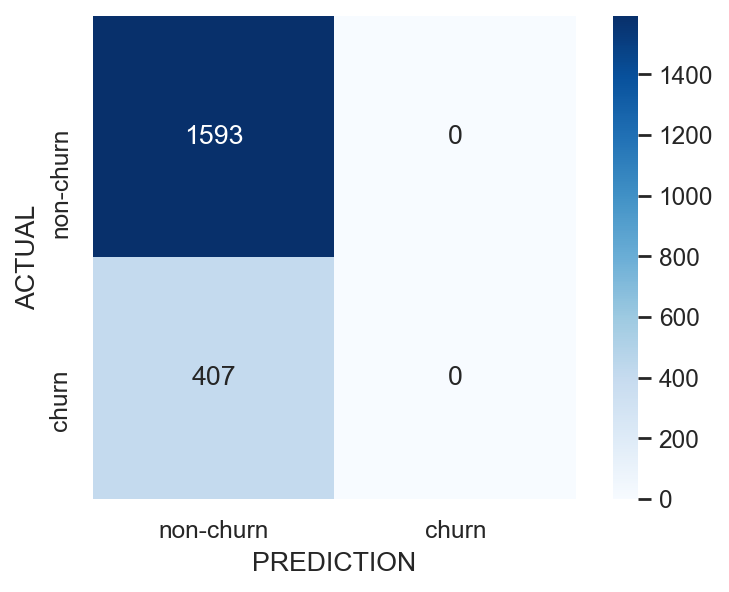

In [128]:
interactive(lambda threshold: make_confusion_matrix(dummy_clf,X_test,y_test, threshold), threshold=(0.0,1.0,0.02))

In [129]:
## Dumb Model-2: predicts all customer NOT CHURN
dummy_clf_2 = DummyClassifier(strategy="constant", constant = 1)
dummy_clf_2.fit(X_trainsc, y_train)
dummy_clf_2.predict(X_trainsc)
print("Dummy Classifier Training Score: ", dummy_clf_2.score(X_trainsc, y_train))
print("Dummy Classifier Test Score: ", dummy_clf_2.score(X_testsc, y_test))

Dummy Classifier Training Score:  0.20375
Dummy Classifier Test Score:  0.2035


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

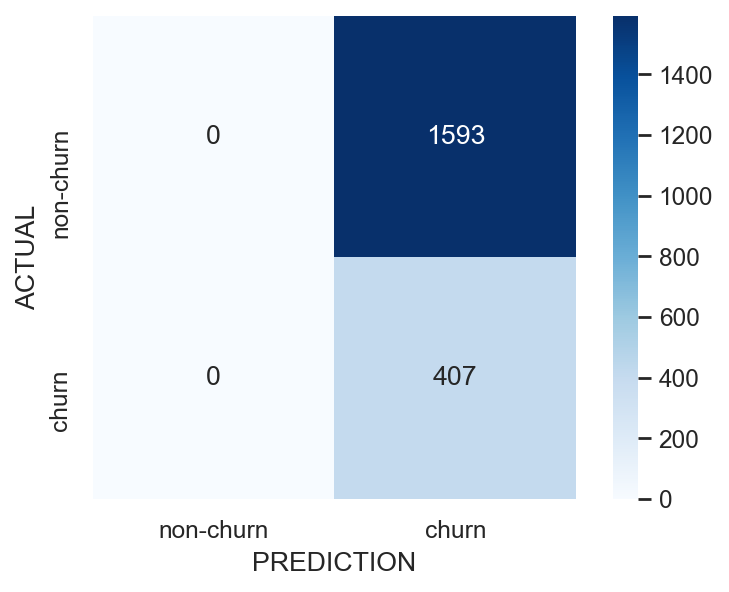

In [130]:
interactive(lambda threshold: make_confusion_matrix(dummy_clf_2,X_test,y_test, threshold), threshold=(0.0,1.0,0.02))

## GridSearchCV

Use Grid-search - to find the optimal hyperparameters of a model (here, classification models) which results in the most ‘accurate’ predictions

In [260]:
def hyperparameters_tuning_with_GridSearchCV(classifier_model, grid_params, classifier_name):

    # Create grid search object
    gridcv_clf = GridSearchCV(classifier_model, param_grid = grid_params,cv=5,scoring = 'recall')

    gridcv_clf.fit(X_trainsc, y_train)
    
    print(classifier_name, " Recall Score: ", gridcv_clf.best_score_)
    print(classifier_name, "Best Params from GridSearchCV: ", gridcv_clf.best_params_)
    print(classifier_name, " Best Estimator: ", gridcv_clf.best_estimator_)
    
    return gridcv_clf

## Logistic Regression

In [261]:
logistic_reg_clf = LogisticRegression(max_iter=100)

# Create param grid.
c_range = [0.001,0.005, 0.009, 0.01,0.09,0.05,1,5] # C - Inverse of regularization strength
grid_values = dict(C=c_range, penalty = ["l1","l2"])

logistic_gridcv = hyperparameters_tuning_with_GridSearchCV(logistic_reg_clf,grid_values, "Logistic Regression")

C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\model_selection\_v

C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\model_selection\_v

C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\vyasc\anaconda3\lib\site-packages\sklearn\model_selection\_v

Logistic Regression  Recall Score:  0.20490797546012268
Logistic Regression Best Params from GridSearchCV:  {'C': 1, 'penalty': 'l2'}
Logistic Regression  Best Estimator:  LogisticRegression(C=1)


In [262]:
lr_clf = LogisticRegression(C = logistic_gridcv.best_params_['C'], max_iter = 100, multi_class='auto', 
                        penalty = logistic_gridcv.best_params_['penalty'])
lr_clf.fit(X_trainsc, y_train)
print("Logistic Training set - Recall Score",lr_clf.score(X_trainsc,y_train))
print("Logistic Test - Recall  Score:", lr_clf.score(X_testsc,y_test))

Logistic Training set - Recall Score 0.812
Logistic Test - Recall  Score: 0.819


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

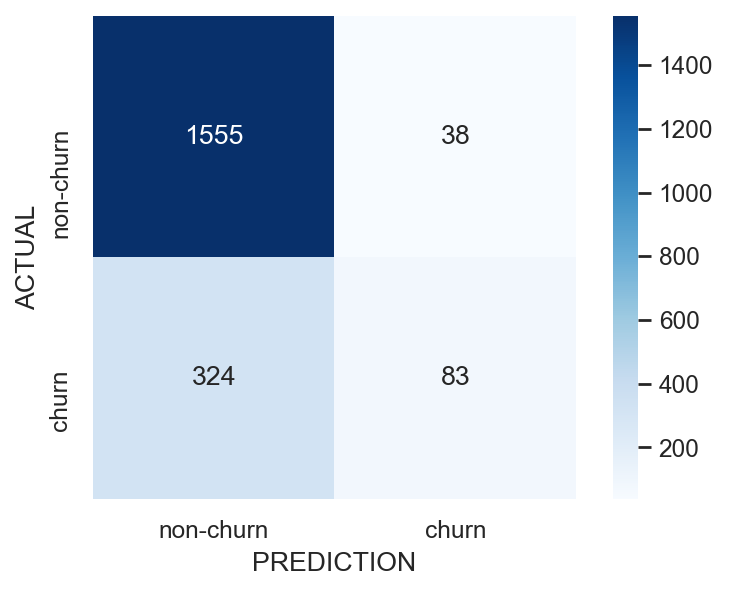

In [263]:
interactive(lambda threshold: make_confusion_matrix(lr_clf,X_testsc,y_test, threshold), threshold=(0.0,1.0,0.02))
# plt.savefig('Logistic_regression_Confusion.png')

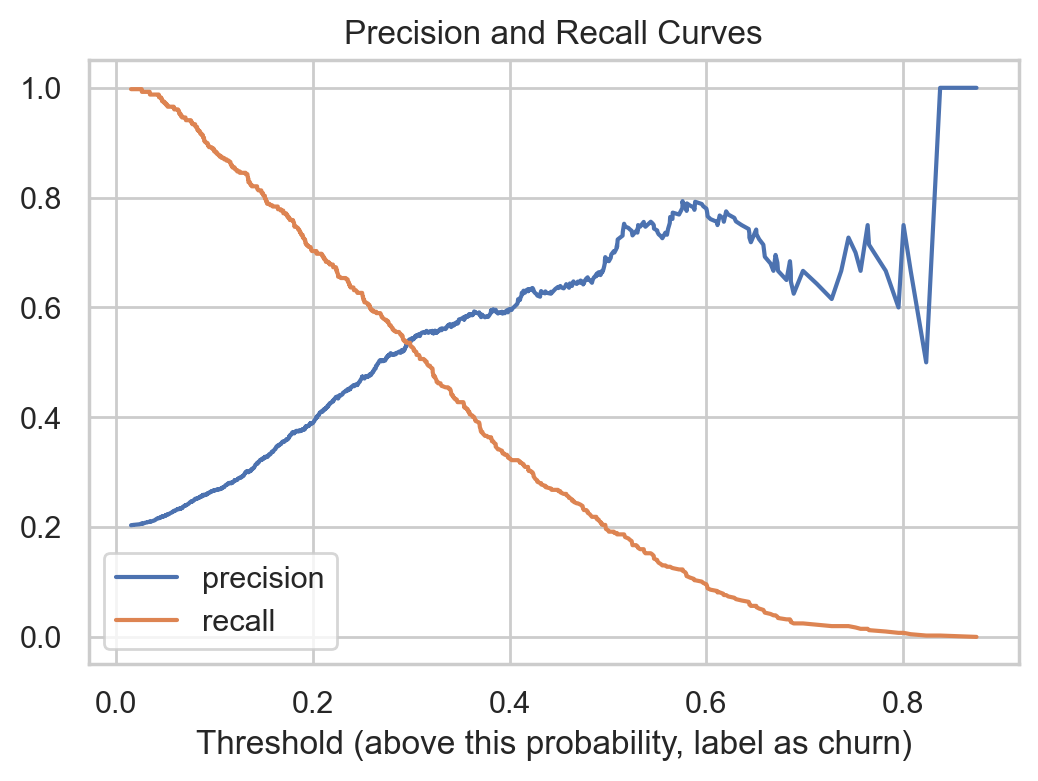

In [145]:
get_precision_recall_curve(lr_clf,y_test,X_testsc)

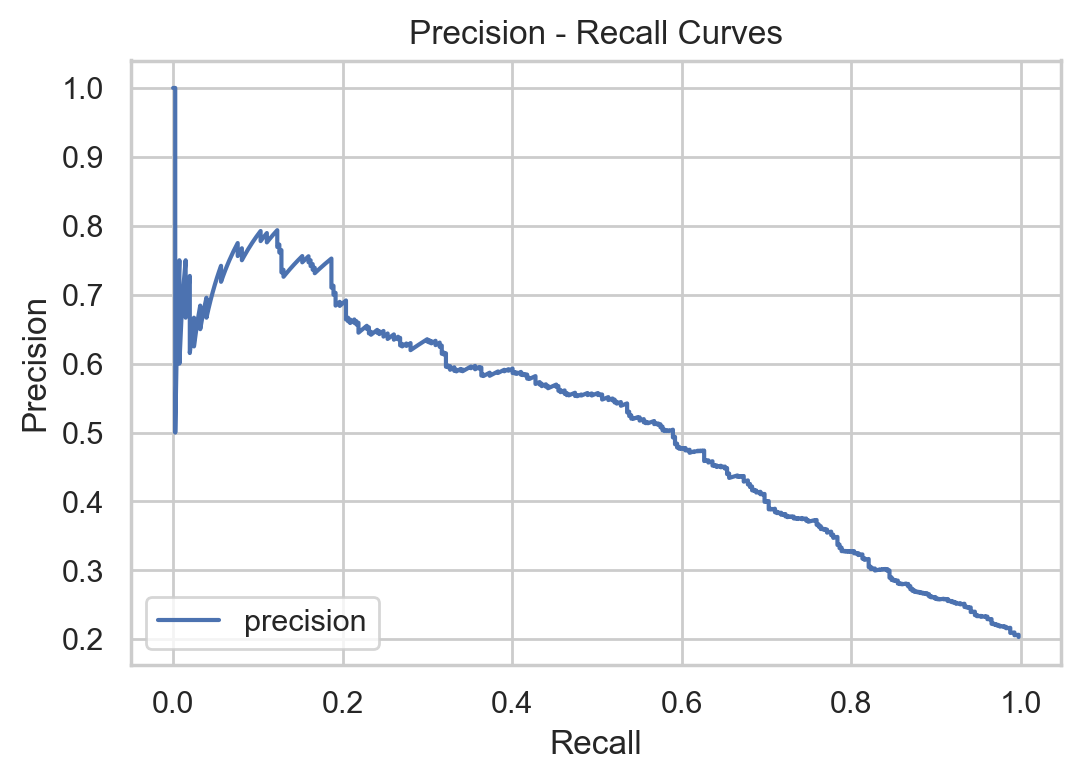

In [158]:
get_precisionVsRecall_curve(lr_clf,y_test,X_testsc)

###  Feature Interpretation for Logistic Regression

In [298]:
col = pd.Series(X_train.columns)
coeff_df = pd.DataFrame(lr_clf.coef_.reshape(-1,1), columns=['Coefficients'])
coeff_df = pd.concat([coeff_df,col], axis=1)
coeff_df = coeff_df.rename({0:"Features"}, axis =1)
coeff_df.sort_values('Coefficients', ascending = False)

,Coefficients,Features
1,0.740140,Age
8,0.317412,Germany
3,0.168616,Balance
7,0.025406,EstimatedSalary
9,0.005265,Spain
5,-0.024056,HasCrCard
0,-0.044915,CreditScore
2,-0.052508,Tenure
4,-0.067513,NumOfProducts
10,-0.252289,Male


## K - Nearest Neighbours CLassifier

In [290]:
knn = KNeighborsClassifier()

k_range = np.arange(5,20)
# weight_options = ['uniform', 'distance']

knn_grid_params = dict(n_neighbors = k_range)

knn_gridcv = hyperparameters_tuning_with_GridSearchCV(knn,knn_grid_params, "K Nearest Neighbours")

# Weight function used in prediction. Possible values:
#‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
#‘distance’ : weight points by the inverse of their distance. 
# Closer neighbors of a query point will have a greater influence than neighbors which are further away.


K Nearest Neighbours  Recall Score:  0.36871165644171777
K Nearest Neighbours Best Params from GridSearchCV:  {'n_neighbors': 5}
K Nearest Neighbours  Best Estimator:  KNeighborsClassifier()


In [291]:
knn_clf = KNeighborsClassifier(n_neighbors = knn_gridcv.best_params_['n_neighbors'])
knn_clf.fit(X_trainsc, y_train)

print("KNN Training set - Recall Score", knn_clf.score(X_trainsc,y_train))
print("KNN  Test set - Recall  Score:", knn_clf.score(X_testsc,y_test))

KNN Training set - Recall Score 0.868875
KNN  Test set - Recall  Score: 0.835


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

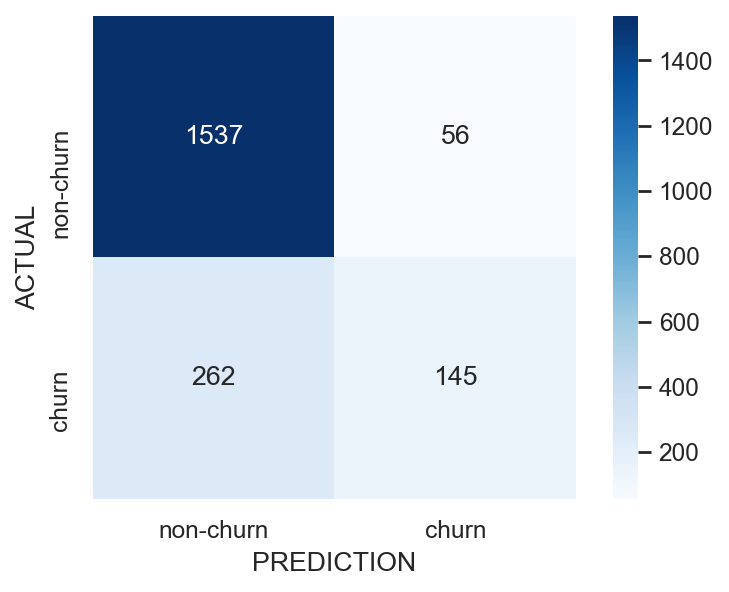

In [266]:
interactive(lambda threshold: make_confusion_matrix(knn_clf,X_testsc,y_test, threshold), threshold=(0.0,1.0,0.02))

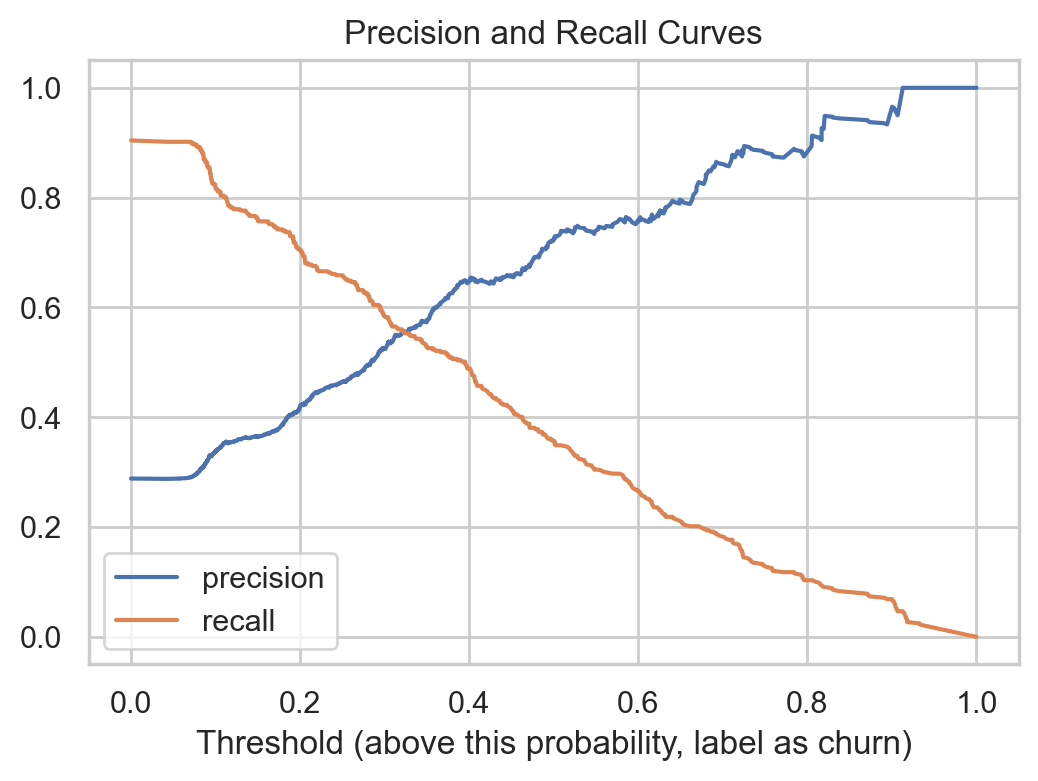

In [207]:
get_precision_recall_curve(knn_clf,y_test,X_testsc)

## Decision Tree Classifier

In [195]:
dtree = DecisionTreeClassifier()

depths = np.arange(2,15)
dtree_gridcv_params = dict(max_depth = depths, min_samples_split = range(2,15))

# min_samples_split - The minimum number of samples required to split an internal node
# Measure the quality of a split (default=”gini”): criteria are “gini” - Gini impurity & “entropy” - information gain.

dtree_gridcv = hyperparameters_tuning_with_GridSearchCV(dtree,dtree_gridcv_params, "Decision Tree")
print(dtree_gridcv)

Decision Tree  Recall Score:  0.4889570552147239
Decision Tree Best Params from GridSearchCV:  {'max_depth': 14, 'min_samples_split': 2}
Decision Tree  Best Estimator:  DecisionTreeClassifier(max_depth=14)
GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'min_samples_split': range(2, 15)},
             scoring='recall')


In [212]:
dtree_clf = DecisionTreeClassifier(max_depth = dtree_gridcv.best_params_['max_depth'],
                                 min_samples_split=dtree_gridcv.best_params_['min_samples_split'])
                            
dtree_clf.fit(X_trainsc, y_train)

print("Decision Tree - Recall Score",dtree_clf.score(X_trainsc,y_train))
print("Decision Tree  Test set  - Recall  Score:", dtree_clf.score(X_testsc,y_test))

Decision Tree - Recall Score 0.9565
Decision Tree - Recall  Score: 0.8165


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

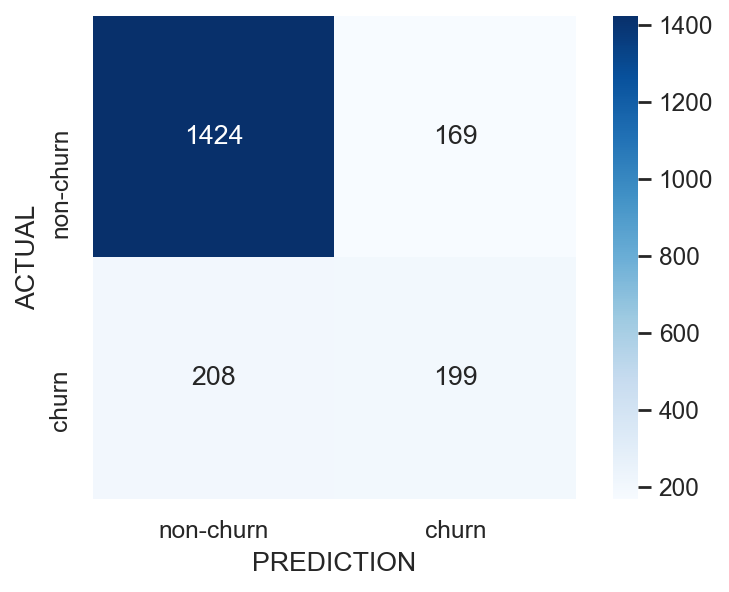

In [206]:
interactive(lambda threshold: make_confusion_matrix(dtree_clf,X_testsc,y_test, threshold), threshold=(0.0,1.0,0.02))

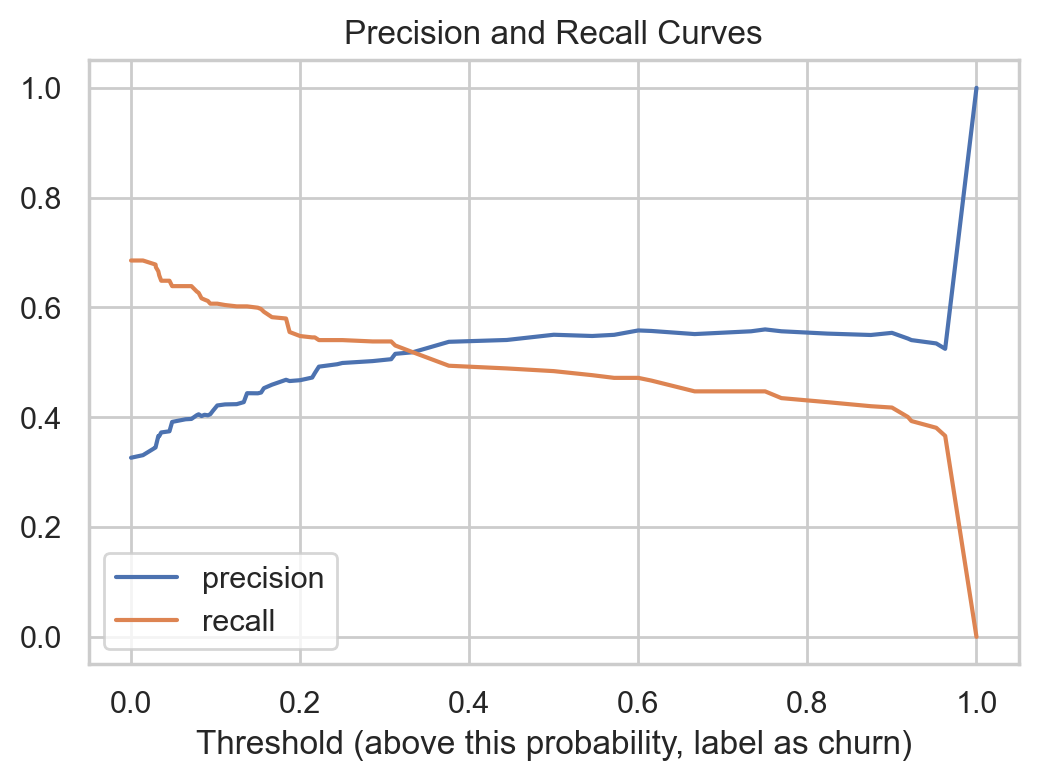

In [208]:
get_precision_recall_curve(dtree_clf,y_test,X_testsc)

###  Feature Interpretation for Decision Tree

In [218]:
col = pd.Series(X_train.columns)
coeff_df = pd.DataFrame(dtree_clf.feature_importances_.reshape(-1,1), columns=['Coefficients'])
coeff_df = pd.concat([coeff_df,col], axis=1)
coeff_df = coeff_df.rename({0:"Features"}, axis =1)
coeff_df.sort_values('Coefficients', ascending = False)

,Coefficients,Features
1,0.254055,Age
3,0.159220,Balance
4,0.148584,NumOfProducts
7,0.133486,EstimatedSalary
0,0.115781,CreditScore
6,0.069891,IsActiveMember
2,0.044663,Tenure
8,0.024950,Germany
10,0.022284,Male
9,0.017210,Spain


## Random Forest

It runs forever when I try to do the hyperparameters_tuning_with_GridSearchCV.
For this purpose, I am assuming values for Random FOrest Classifier: n_estimators, max_depth, max_features


In [227]:
rforest = RandomForestClassifier()

rforest_range = np.arange(1,30)
maxdepth_range = np.arange(2,15)
rf_grid_params = dict(n_estimators = rforest_range, max_depth=maxdepth_range, max_features= ['auto', 'sqrt', 'log2'])

# n_estimatorsint, default=100 - The number of trees in the forest.
# max_features{“auto”, “sqrt”, “log2”} - The number of features to consider when looking for the best split:
#  EG: If “sqrt”, then max_features=sqrt(n_features) (same as “auto”)
#      If “log2”, then max_features=log2(n_features)

rforest_gridcv = hyperparameters_tuning_with_GridSearchCV(rforest,rf_grid_params, "Random Forest")
print(rforest_gridcv)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
             scoring='recall')


In [ ]:
# rf_clf = RandomForestClassifier(n_estimators=rforest_gridcv.best_params_['n_estimators'],
#                                 max_depth =rforest_gridcv.best_params_['max_depth'],
#                                 max_features=rforest_gridcv.best_params_['max_features'])

In [230]:
rf_clf = RandomForestClassifier(n_estimators=12, max_depth =5, max_features='auto')
rf_clf.fit(X_trainsc, y_train)

print("Random Forest - Recall Score",rf_clf.score(X_trainsc,y_train))
print("Random Forest Test set - Recall  Score:", rf_clf.score(X_testsc,y_test))

Random Forest - Recall Score 0.843375
Random Forest - Recall  Score: 0.844


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

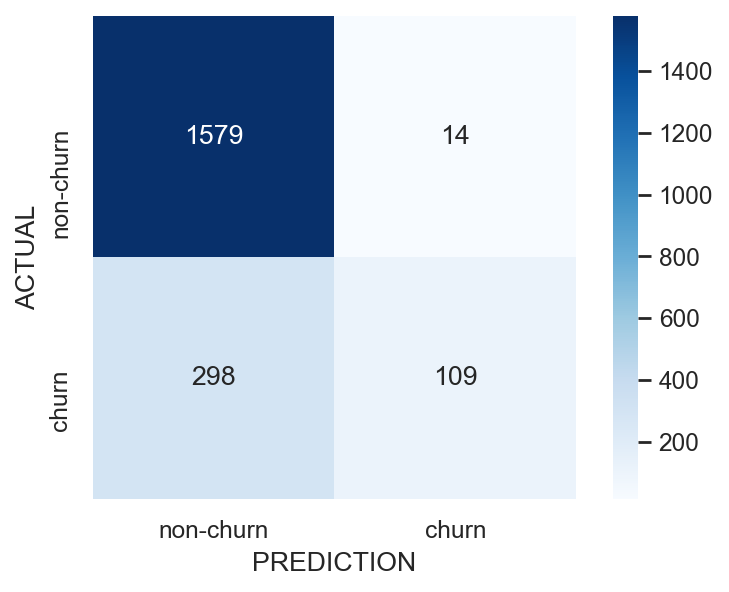

In [231]:
interactive(lambda threshold: make_confusion_matrix(rf_clf,X_testsc,y_test, threshold), threshold=(0.0,1.0,0.02))

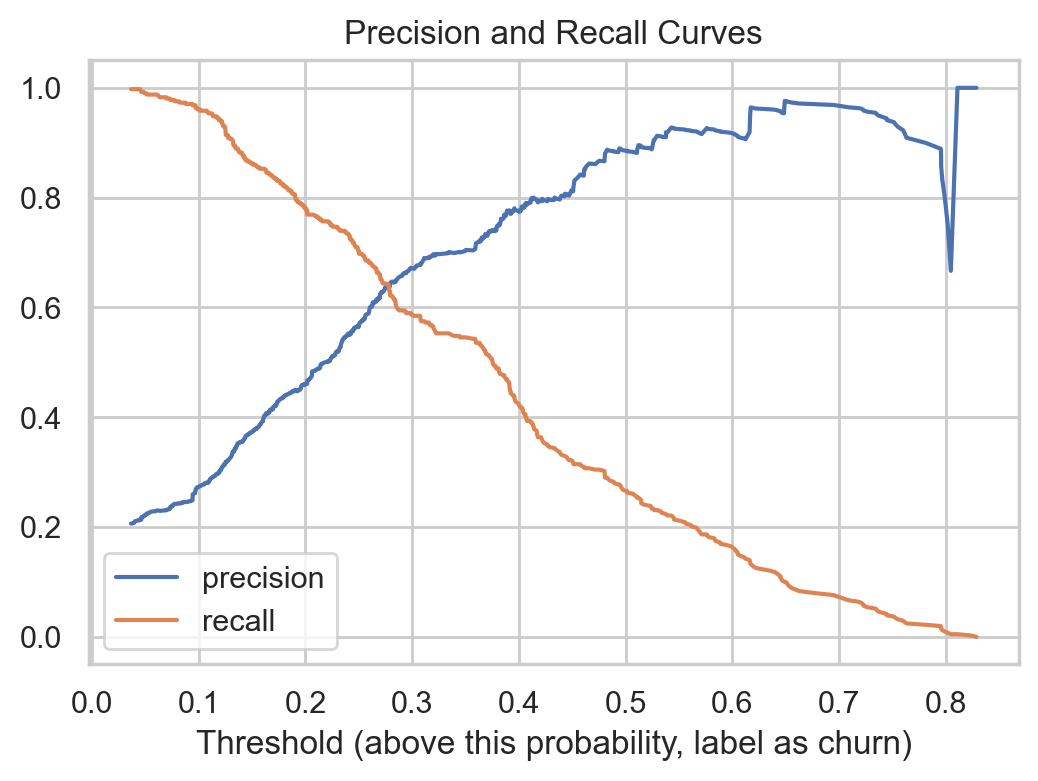

In [232]:
get_precision_recall_curve(rf_clf,y_test,X_testsc)

###  Feature Interpretation for Random Forest

In [233]:
col = pd.Series(X_train.columns)
coeff_df = pd.DataFrame(rf_clf.feature_importances_.reshape(-1,1), columns=['Coefficients'])
coeff_df = pd.concat([coeff_df,col], axis=1)
coeff_df = coeff_df.rename({0:"Features"}, axis =1)
coeff_df.sort_values('Coefficients', ascending = False)

,Coefficients,Features
1,0.373287,Age
4,0.326764,NumOfProducts
8,0.086123,Germany
6,0.083849,IsActiveMember
3,0.065781,Balance
0,0.022811,CreditScore
10,0.020450,Male
7,0.015435,EstimatedSalary
2,0.004666,Tenure
5,0.000519,HasCrCard


## XGBoost - Extreme Gradient Boosting

In [237]:
import xgboost
xgb = xgboost.XGBClassifier(use_label_encoder=False, eval_metric='auc')
xgb.fit(X_trainsc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [239]:
print("XGBoost Training set - AUC Score",xgb.score(X_trainsc,y_train))
print("XGBoost Test set - AUC  Score:", xgb.score(X_testsc,y_test))

XGBoost Training set - AUC Score 0.953875
XGBoost Test set - AUC  Score: 0.856


In [242]:
# refer - https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster

xgb_randomized_search_params = {
    "max_depth": [2, 3, 4, 5, 6],
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4]
}
random_cv = RandomizedSearchCV(xgb, param_distributions=xgb_randomized_search_params, n_iter=10, scoring='recall', n_jobs=1, cv=5, verbose=1)

In [243]:
random_cv.fit(X_trainsc,y_train)
print("Best params: ", random_cv.best_params_)
print("Best estimator: ", random_cv.best_estimator_)
print("Best score: ", random_cv.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params:  {'min_child_weight': 7, 'max_depth': 6, 'learning_rate': 0.2, 'gamma': 0.1}
Best estimator:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0.1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
Best score:  0.48650306748466254


In [245]:
xgb_clf = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0.1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=7, monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
xgb_clf.fit(X_trainsc, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0.1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [247]:
print("XGBoost Training set - Recall Score",xgb_clf.score(X_trainsc,y_train))
print("XGBoost Test set - Recall  Score:", xgb_clf.score(X_testsc,y_test))

XGBoost Training set - Recall Score 0.9095
XGBoost Test set - Recall  Score: 0.8695


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

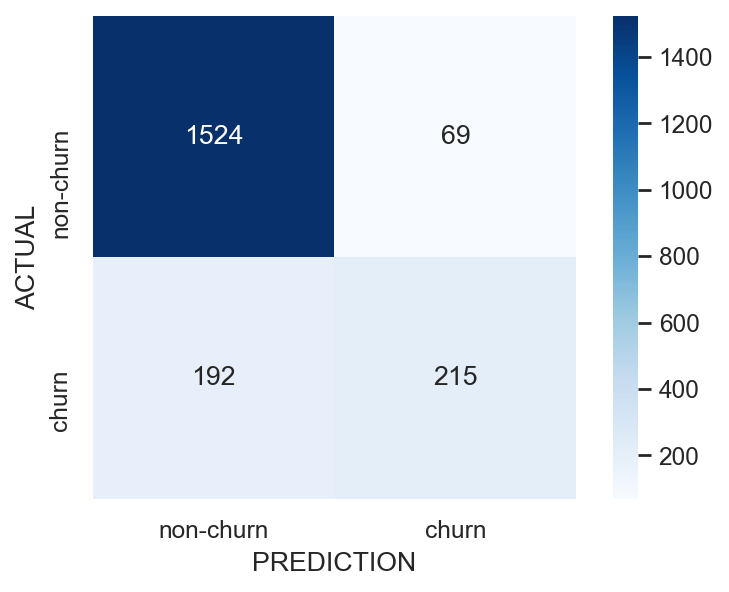

In [248]:
interactive(lambda threshold: make_confusion_matrix(xgb_clf,X_testsc,y_test, threshold), threshold=(0.0,1.0,0.02))

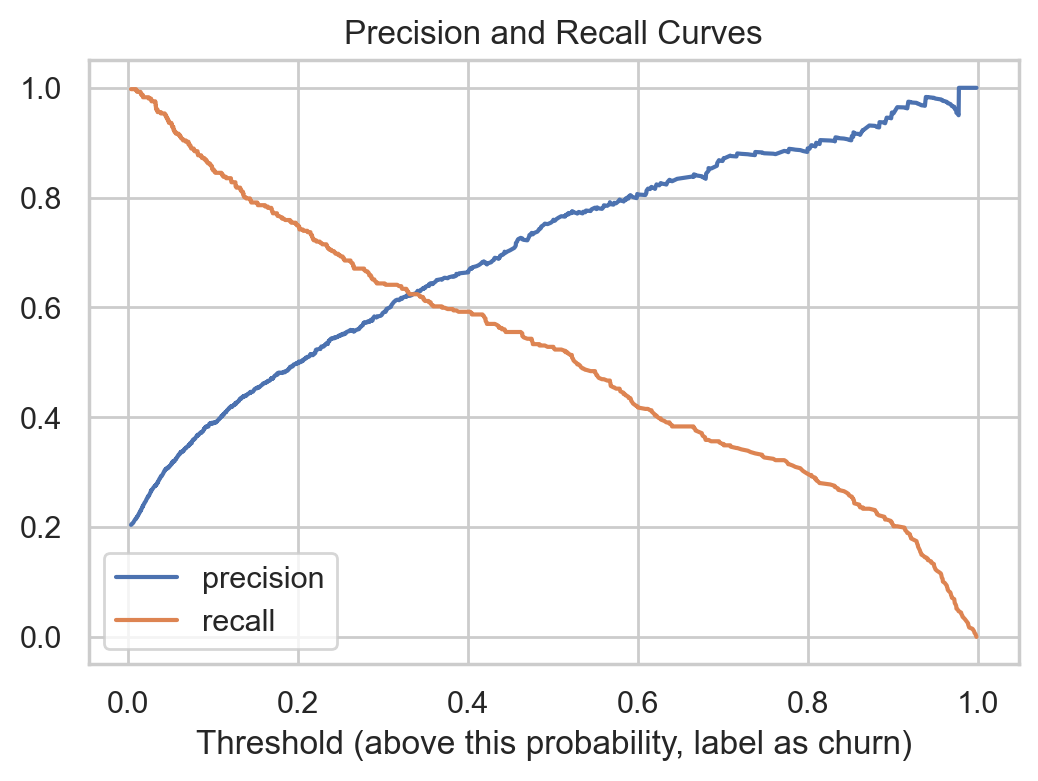

In [250]:
get_precision_recall_curve(xgb_clf,y_test,X_testsc)

###  Feature Interpretation for XGBoost

In [251]:
col = pd.Series(X_train.columns)
coeff_df = pd.DataFrame(xgb_clf.feature_importances_.reshape(-1,1), columns=['Coefficients'])
coeff_df = pd.concat([coeff_df,col], axis=1)
coeff_df = coeff_df.rename({0:"Features"}, axis =1)
coeff_df.sort_values('Coefficients', ascending = False)

,Coefficients,Features
4,0.301469,NumOfProducts
6,0.169982,IsActiveMember
1,0.163032,Age
8,0.089339,Germany
3,0.056229,Balance
9,0.047886,Spain
10,0.044737,Male
2,0.033435,Tenure
0,0.032193,CreditScore
7,0.031748,EstimatedSalary


## ROC curve
ROC plots true positive rate (recall) vs. false positive rate for a given probability decision threshold. So you should loop over a range of probability cutoffs from 1 to 0, convert a model's predicted probabilities (model.predict_proba()[:,1]) to target labels using each cutoff, and plot the results as a curve.


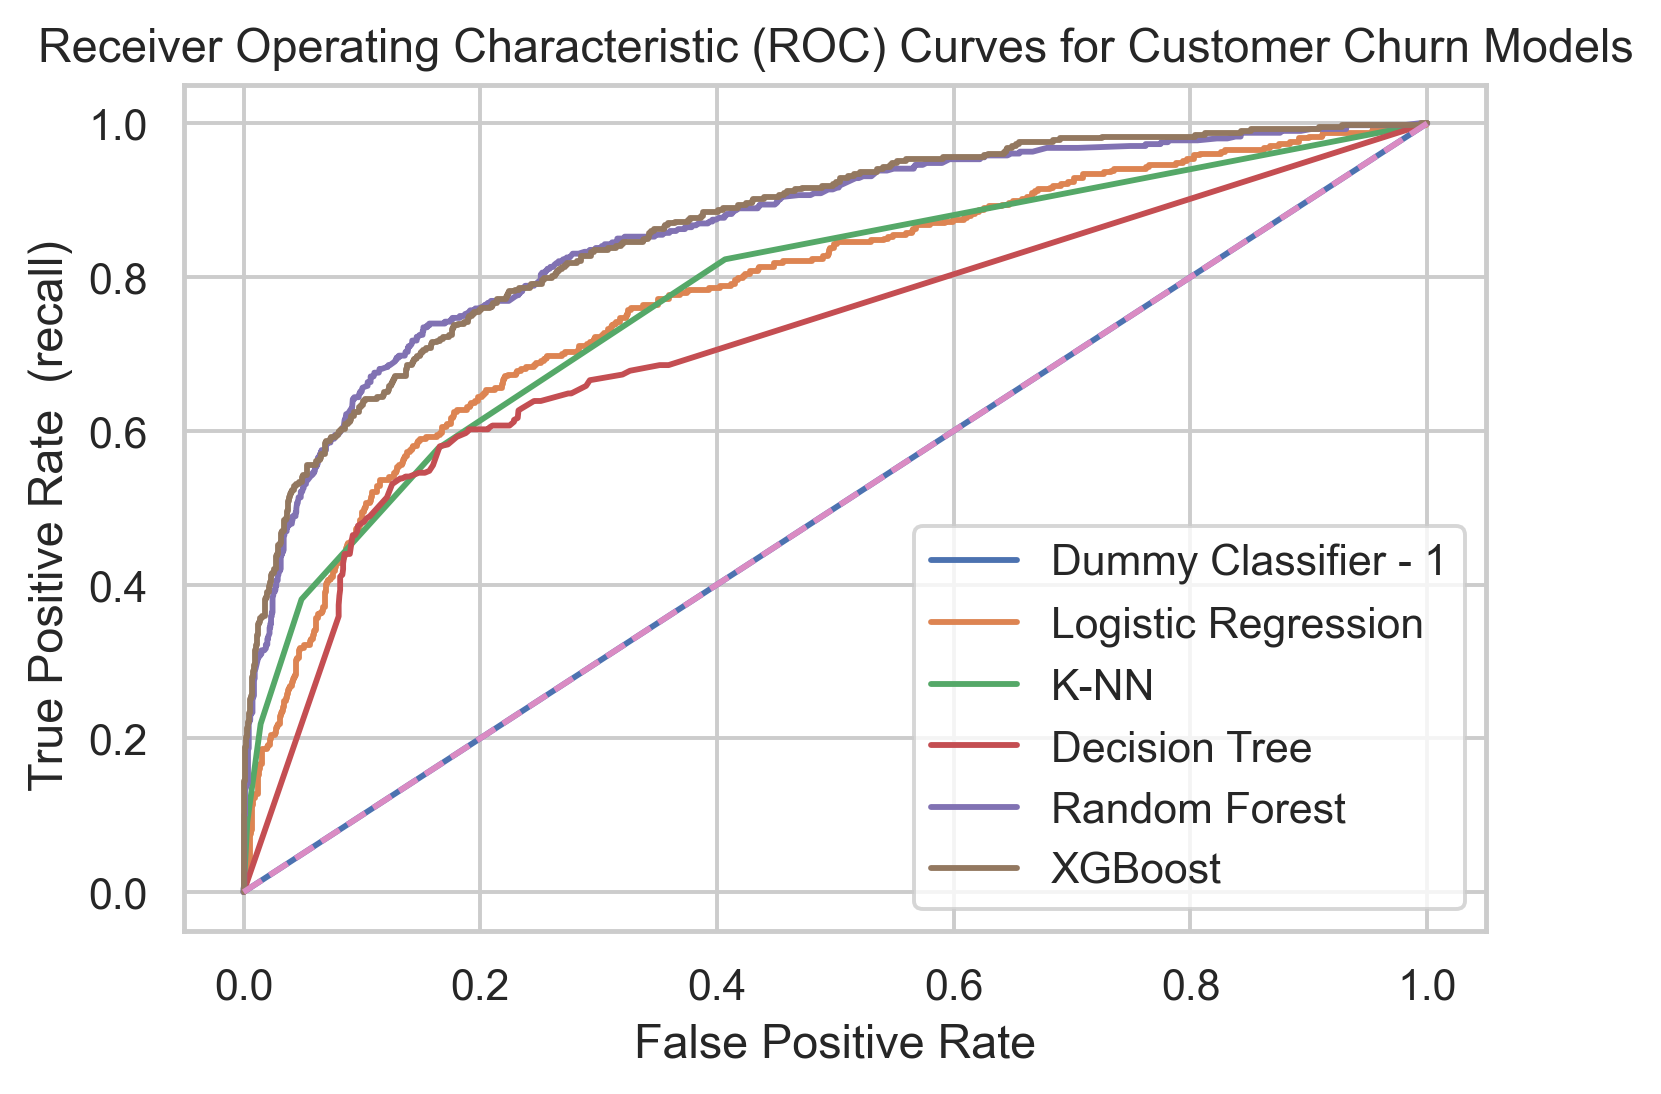

In [305]:
### Score models on test set using Classification Evaluation Metrics
from sklearn.metrics import roc_curve

plt.figure(dpi=140)

fpr, tpr, _ = roc_curve(y_test, dummy_clf.predict_proba(X_testsc)[:,1])
plt.plot(fpr, tpr)

# fpr, tpr, _ = roc_curve(y_test, dummy_clf_2.predict_proba(X_testsc)[:,1])
# plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, lr_clf.predict_proba(X_testsc)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, knn_clf.predict_proba(X_testsc)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, dtree_clf.predict_proba(X_testsc)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, rf_clf.predict_proba(X_testsc)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, xgb_clf.predict_proba(X_testsc)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

# plt.title('ROC Curve')
plt.title('Receiver Operating Characteristic (ROC) Curves for Customer Churn Models');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate  (recall) ')
plt.legend(['Dummy Classifier - 1','Logistic Regression','K-NN', 'Decision Tree', 'Random Forest', 'XGBoost'])

# Future Work

## Scoring Models for Elite Customers vs Non-Elite Customers

Considering optimum Recall for Elite Customers.
Looking into Precision when it comes to non-elite customers.

In [ ]:
X_new = df.loc[:,'CreditScore':'Male']
y_new = df['Exited']

In [ ]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.2, random_state=20)

In [ ]:
X_test_new.info()

In [ ]:
print('Credit Score description \n',X_test_new.CreditScore.describe())

In [ ]:
print('Balance description \n',X_test_new.Balance.describe())

In [ ]:
elite_mask = (X_test_new['CreditScore'] >= 750) & (X_test_new['Balance'] >= 100000)
non_elite_mask = (X_test_new['CreditScore'] <= 600) & (X_test_new['Balance'] <= 10000)

In [ ]:
elite_X_test = X_test_new[elite_mask]
non_elite_X_test = X_test_new[non_elite_mask]

In [ ]:
elite_y_test = y_test_new[elite_mask]
non_elite_y_test = y_test_new[non_elite_mask]

In [ ]:
print(elite_y_test.shape)
print(non_elite_y_test.shape)

In [ ]:
elite_X_test

In [ ]:
get_model_evaluation_scores(rf_model,elite_y_test,elite_X_test)

In [ ]:
print('Confusion Matrix \nElite Customers with Threshold = 0.24')
interactive(lambda threshold: make_confusion_matrix(rf_model,elite_X_test,elite_y_test, threshold), threshold=(0.0,1.0,0.02))

In [ ]:
print('Confusion Matrix \nNon-Elite Customers with Threshold = 0.64')
interactive(lambda threshold: make_confusion_matrix(rf_model,non_elite_X_test, non_elite_y_test, threshold), threshold=(0.0,1.0,0.02))